# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('loan_data_2007_2014.csv')
df.info()

C:\Users\rofik\AppData\Local\Temp\ipykernel_25536\1171339239.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan_data_2007_2014.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [3]:
# Daftar kolom yang ingin disimpan
selected_columns = ['term','home_ownership', 'verification_status', 'loan_status', 
'pymnt_plan', 'purpose', 'initial_list_status', 'annual_inc', 'loan_amnt', 
'int_rate','dti', 'revol_bal', 'total_pymnt','delinq_2yrs', 'inq_last_6mths', 
'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'out_prncp','total_rec_prncp', 'total_rec_int', 
'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 
'issue_d', 'last_pymnt_d', 'earliest_cr_line', 
'last_credit_pull_d','grade', 'emp_length', 'addr_state']

# Memfilter dataset hanya dengan kolom yang diperlukan
df = df[selected_columns]

In [4]:
df.to_csv('credit.csv', index=False)

In [5]:
df = pd.read_csv('credit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        466285 non-null  object 
 1   home_ownership              466285 non-null  object 
 2   verification_status         466285 non-null  object 
 3   loan_status                 466285 non-null  object 
 4   pymnt_plan                  466285 non-null  object 
 5   purpose                     466285 non-null  object 
 6   initial_list_status         466285 non-null  object 
 7   annual_inc                  466281 non-null  float64
 8   loan_amnt                   466285 non-null  int64  
 9   int_rate                    466285 non-null  float64
 10  dti                         466285 non-null  float64
 11  revol_bal                   466285 non-null  int64  
 12  total_pymnt                 466285 non-null  float64
 13  delinq_2yrs   

In [6]:
df.columns

Index(['term', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'annual_inc',
       'loan_amnt', 'int_rate', 'dti', 'revol_bal', 'total_pymnt',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d',
       'grade', 'emp_length', 'addr_state'],
      dtype='object')

In [7]:
# Perbaiki fungsi untuk konversi full year
def convert_to_full_year_with_month(data_str):
    if pd.isnull(data_str):
        return None
    month, year = data_str.split('-')
    year = int(year)
    if year >= 40:  # Asumsikan data sebelum tahun 1940 tidak ada
        year_str = f'19{year}'
    else:
        year_str = f'20{year:02d}'
    return f'{month}-{year_str}'

In [8]:
# Terapkan fungsi konversi ke setiap kolom
date_columns = ['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']
for col in date_columns:
    df[col] = df[col].apply(convert_to_full_year_with_month)
    df[col] = pd.to_datetime(df[col], format='%b-%Y')

# Menghitung payment_time dalam bulan
df['payment_time'] = (df['last_pymnt_d'].dt.year - df['issue_d'].dt.year) * 12 + \
                     (df['last_pymnt_d'].dt.month - df['issue_d'].dt.month)

# Menghitung loan_time dalam bulan
df['loan_time'] = (df['last_credit_pull_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + \
                  (df['last_credit_pull_d'].dt.month - df['earliest_cr_line'].dt.month)

# Tampilkan DataFrame
df

term home_ownership verification_status  loan_status pymnt_plan  \
0        36 months           RENT            Verified   Fully Paid          n   
1        60 months           RENT     Source Verified  Charged Off          n   
2        36 months           RENT        Not Verified   Fully Paid          n   
3        36 months           RENT     Source Verified   Fully Paid          n   
4        60 months           RENT     Source Verified      Current          n   
...            ...            ...                 ...          ...        ...   
466280   60 months       MORTGAGE     Source Verified      Current          n   
466281   60 months       MORTGAGE            Verified  Charged Off          n   
466282   60 months       MORTGAGE            Verified      Current          n   
466283   36 months            OWN            Verified   Fully Paid          n   
466284   36 months       MORTGAGE            Verified      Current          n   

                   purpose initial_list_status  annual_inc  loan_amnt  \
0              credit_card                   f     24000.0       5000   
1                      car                   f     30000.0       2500   
2           small_business                   f     12252.0       2400   
3                    other                   f     49200.0      10000   
4                    other                   f     80000.0       3000   
...                    ...                 ...         ...        ...   
466280  debt_consolidation                   w    110000.0      18400   
466281  debt_consolidation                   f     78000.0      22000   
466282  debt_consolidation                   f     46000.0      20700   
466283         credit_card                   w     83000.0       2000   
466284               other                   f     46000.0      10000   

        int_rate  ...  acc_now_delinq    issue_d  last_pymnt_d  \
0          10.65  ...             0.0 2011-12-01    2015-01-01   
1          15.27  ...             0.0 2011-12-01    2013-04-01   
2          15.96  ...             0.0 2011-12-01    2014-06-01   
3          13.49  ...             0.0 2011-12-01    2015-01-01   
4          12.69  ...             0.0 2011-12-01    2016-01-01   
...          ...  ...             ...        ...           ...   
466280     14.47  ...             0.0 2014-01-01    2016-01-01   
466281     19.97  ...             0.0 2014-01-01    2014-12-01   
466282     16.99  ...             0.0 2014-01-01    2016-01-01   
466283      7.90  ...             0.0 2014-01-01    2014-12-01   
466284     19.20  ...             0.0 2014-01-01    2016-01-01   

        earliest_cr_line  last_credit_pull_d  grade  emp_length  addr_state  \
0             1985-01-01          2016-01-01      B   10+ years          AZ   
1             1999-04-01          2013-09-01      C    < 1 year          GA   
2             2001-11-01          2016-01-01      C   10+ years          IL   
3             1996-02-01          2015-01-01      C   10+ years          CA   
4             1996-01-01          2016-01-01      B      1 year          OR   
...                  ...                 ...    ...         ...         ...   
466280        2003-04-01          2016-01-01      C     4 years          TX   
466281        1997-06-01          2016-01-01      D   10+ years          TN   
466282        2001-12-01          2015-12-01      D     7 years          OH   
466283        2003-02-01          2015-04-01      A     3 years          CA   
466284        2000-02-01          2016-01-01      D   10+ years          CA   

        payment_time  loan_time  
0               37.0      372.0  
1               16.0      173.0  
2               30.0      170.0  
3               37.0      227.0  
4               49.0      240.0  
...              ...        ...  
466280          24.0      153.0  
466281          11.0      223.0  
466282          24.0      168.0  
466283          11.0      146.0  
466284          24.0      191.0  

[466285 rows 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   term                        466285 non-null  object        
 1   home_ownership              466285 non-null  object        
 2   verification_status         466285 non-null  object        
 3   loan_status                 466285 non-null  object        
 4   pymnt_plan                  466285 non-null  object        
 5   purpose                     466285 non-null  object        
 6   initial_list_status         466285 non-null  object        
 7   annual_inc                  466281 non-null  float64       
 8   loan_amnt                   466285 non-null  int64         
 9   int_rate                    466285 non-null  float64       
 10  dti                         466285 non-null  float64       
 11  revol_bal                   466285 non-

In [10]:
# df = df.drop(columns=['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   term                        466285 non-null  object        
 1   home_ownership              466285 non-null  object        
 2   verification_status         466285 non-null  object        
 3   loan_status                 466285 non-null  object        
 4   pymnt_plan                  466285 non-null  object        
 5   purpose                     466285 non-null  object        
 6   initial_list_status         466285 non-null  object        
 7   annual_inc                  466281 non-null  float64       
 8   loan_amnt                   466285 non-null  int64         
 9   int_rate                    466285 non-null  float64       
 10  dti                         466285 non-null  float64       
 11  revol_bal                   466285 non-

# EDA

# Univariate Analysis

In [12]:
loan_status_order = df['loan_status'].value_counts().index

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Current'),
  Text(1, 0, 'Fully Paid'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'Late (31-120 days)'),
  Text(4, 0, 'In Grace Period'),
  Text(5, 0, 'Does not meet the credit policy. Status:Fully Paid'),
  Text(6, 0, 'Late (16-30 days)'),
  Text(7, 0, 'Default'),
  Text(8, 0, 'Does not meet the credit policy. Status:Charged Off')])

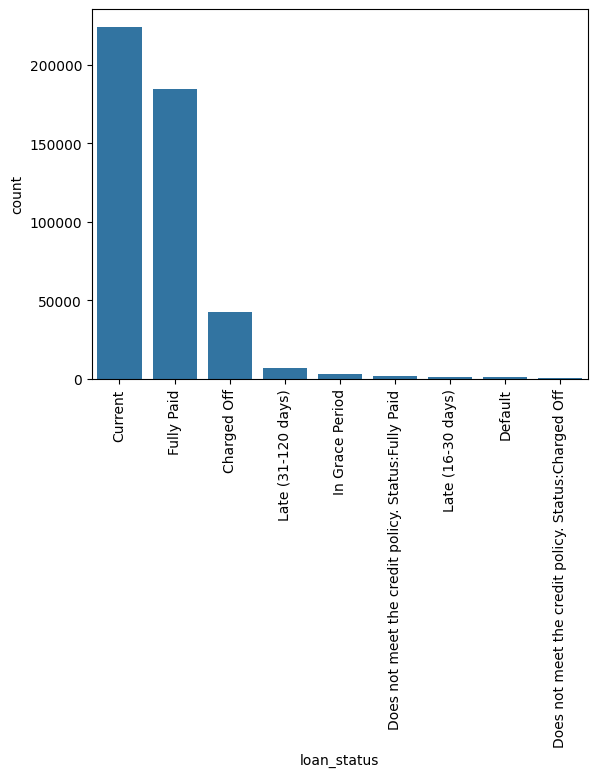

In [13]:
sns.countplot(data=df, x='loan_status', order=loan_status_order)
plt.xticks(rotation=90)

In [14]:
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 2,  # Status ongoing
    'In Grace Period': 2,  # Status ongoing
    'Charged Off': 0,
    'Default': 0,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 2,  # Status ongoing
    'Does not meet the credit policy. Status:Fully Paid': 1,  # Good
    'Does not meet the credit policy. Status:Charged Off': 0
}

# Mapping nilai ke kolom class_loan
df['class_loan'] = df['loan_status'].map(loan_status_mapping)

# Memastikan tipe data numerik
df['class_loan'] = df['class_loan'].astype(int)

# Menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   term                        466285 non-null  object        
 1   home_ownership              466285 non-null  object        
 2   verification_status         466285 non-null  object        
 3   loan_status                 466285 non-null  object        
 4   pymnt_plan                  466285 non-null  object        
 5   purpose                     466285 non-null  object        
 6   initial_list_status         466285 non-null  object        
 7   annual_inc                  466281 non-null  float64       
 8   loan_amnt                   466285 non-null  int64         
 9   int_rate                    466285 non-null  float64       
 10  dti                         466285 non-null  float64       
 11  revol_bal                   466285 non-

In [15]:
filt_data = df[df['class_loan']!=2]
class_loan_count = filt_data['class_loan'].value_counts()
class_loan_count

class_loan
1    186727
0     50968
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1765d466650>,
 [Text(-0.6862178513518711, -0.8597121963110804, '1'),
  Text(0.6862178111058376, 0.8597122284352557, '0')],
 [Text(-0.37430064619192965, -0.46893392526058925, '78.6%'),
  Text(0.37430062423954774, 0.4689339427828667, '21.4%')])

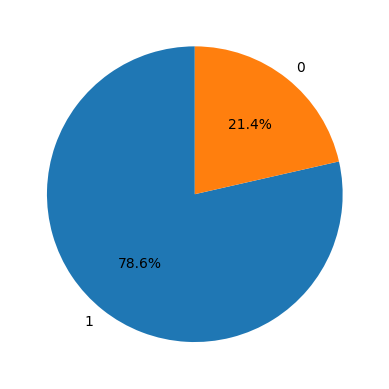

In [16]:
plt.pie(class_loan_count, labels=class_loan_count.index, autopct='%1.1f%%', startangle=90)

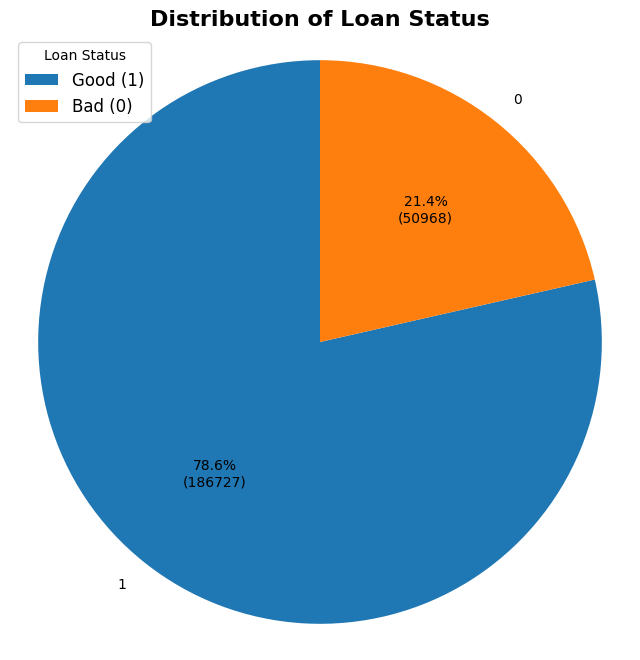

In [17]:
# Membuat Pie Chart dengan persentase di dalam pie chart
plt.figure(figsize=(8, 8))

# Menambahkan label custom dengan persentase dan jumlah data
def func(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f'{pct:.1f}%\n({absolute})'

plt.pie(class_loan_count, labels=class_loan_count.index, 
        autopct=lambda pct: func(pct, class_loan_count), startangle=90, colors=['#1f77b4', '#ff7f0e'])

plt.legend(['Good (1)', 'Bad (0)'], title="Loan Status", loc="upper left", fontsize=12)
plt.title('Distribution of Loan Status', fontsize=16, fontweight='bold')
plt.axis('equal')  
plt.show()

In [18]:
cat = []  
num = []  

for i in filt_data.columns:
    if filt_data[i].dtype == 'object':  
        if filt_data[i].nunique() <= 10:  
            cat.append(i)
        else:
            pass  
    elif filt_data[i].dtype in ['int64', 'float64']:  
        num.append(i)

print('Fitur Kategorik:', cat)
print('Fitur Numerik:', num)

Fitur Kategorik: ['term', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'grade']
Fitur Numerik: ['annual_inc', 'loan_amnt', 'int_rate', 'dti', 'revol_bal', 'total_pymnt', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'payment_time', 'loan_time']


In [19]:
cat = ['term', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'grade', 'emp_length', 'purpose']
num = ['annual_inc', 'loan_amnt', 'int_rate', 'dti', 'revol_bal', 
       'total_pymnt']

In [20]:
filt_data['term'].value_counts()

term
 36 months    185700
 60 months     51994
60 months          1
Name: count, dtype: int64

In [21]:
df['term'] = df['term'].str.strip()

In [22]:
df['term'].value_counts()

term
36 months    337953
60 months    128332
Name: count, dtype: int64

## Univariate Fitur Kategorik

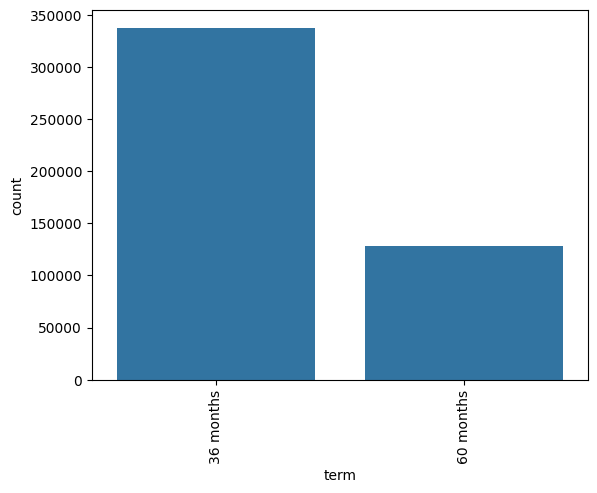

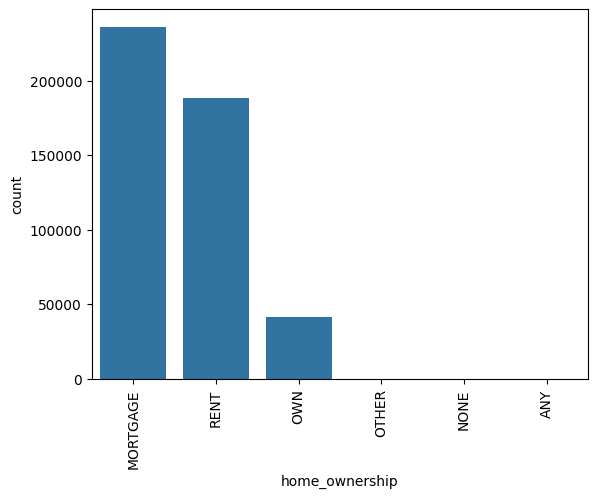

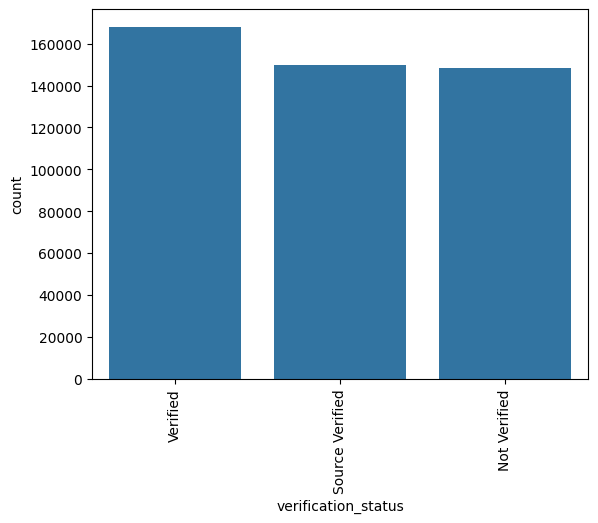

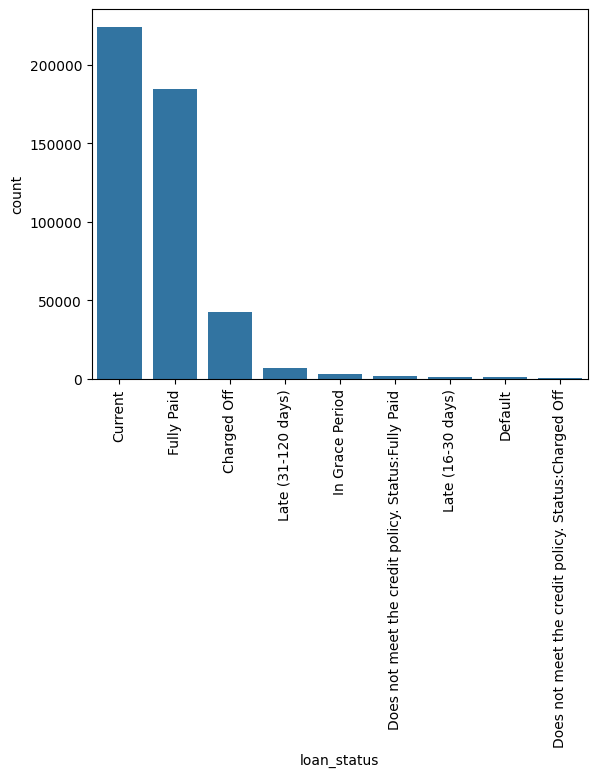

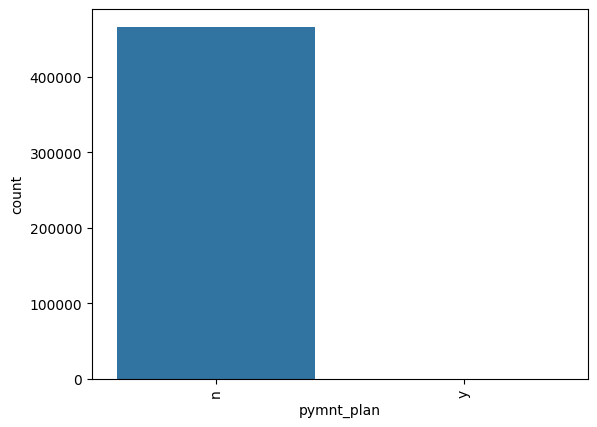

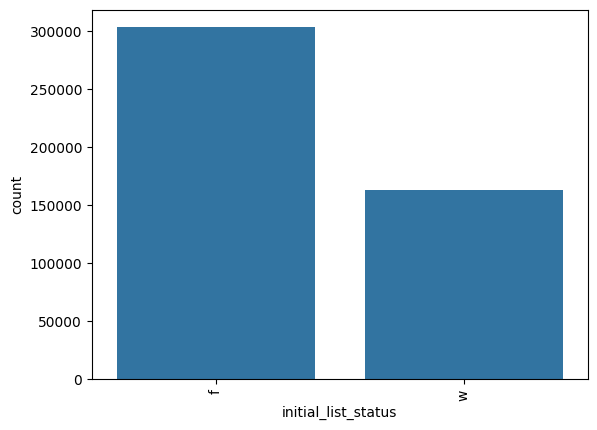

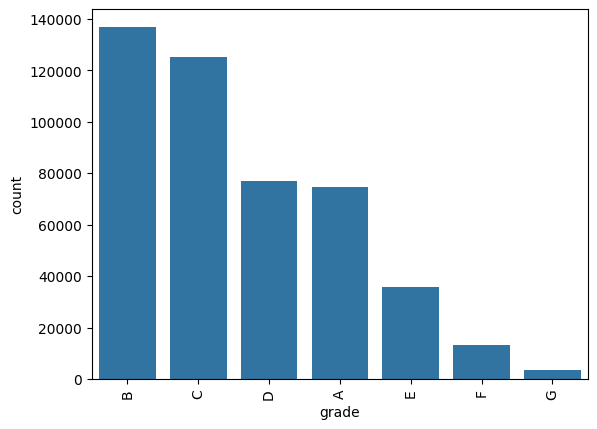

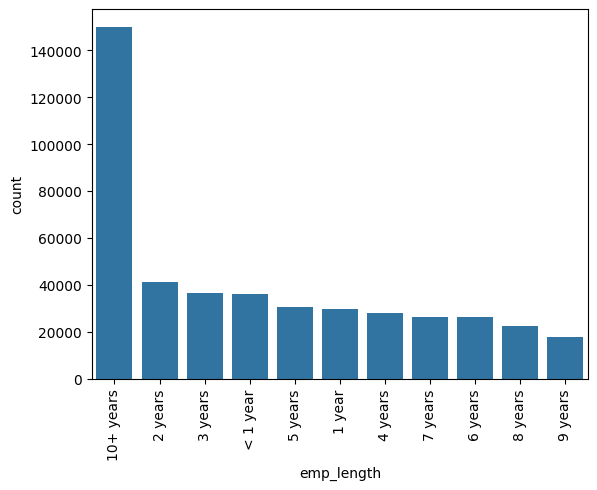

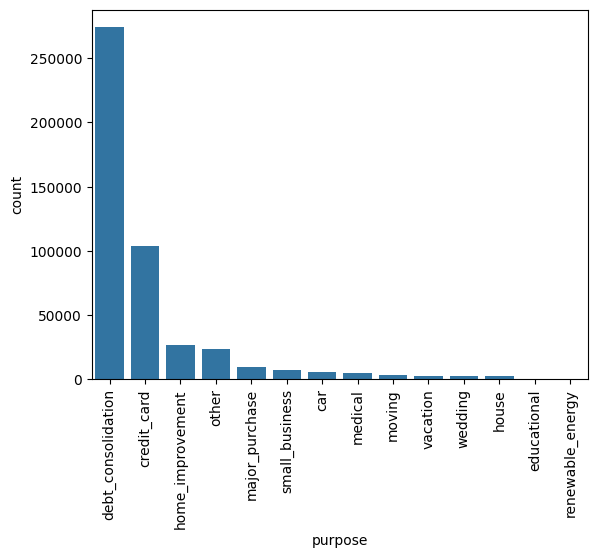

In [23]:
for i in cat:
    order = df[i].value_counts().index
    sns.countplot(data=df, x=i, order=order)
    plt.xticks(rotation=90)
    plt.show()

## Univariate Fitur Numerik

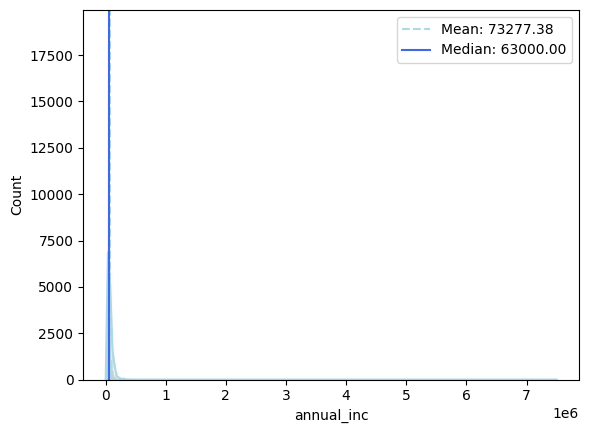

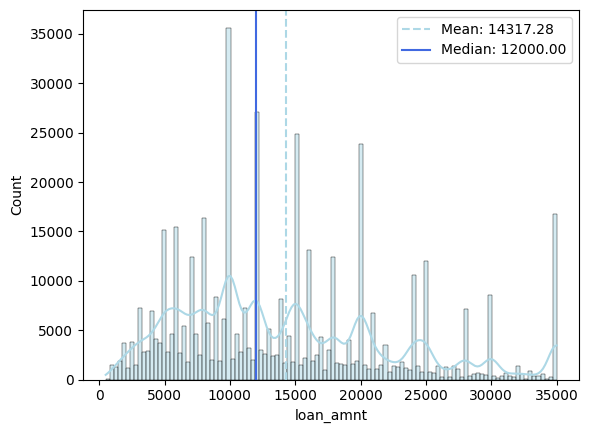

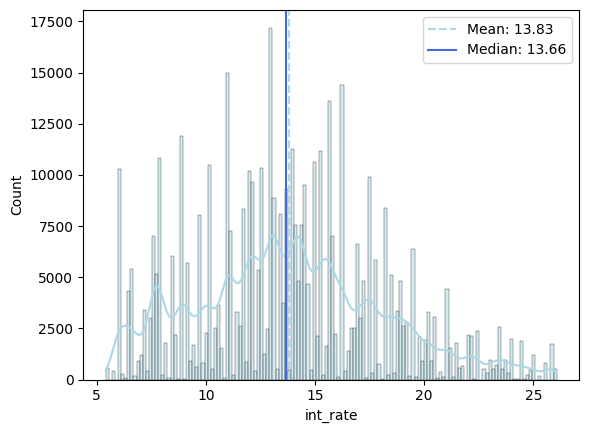

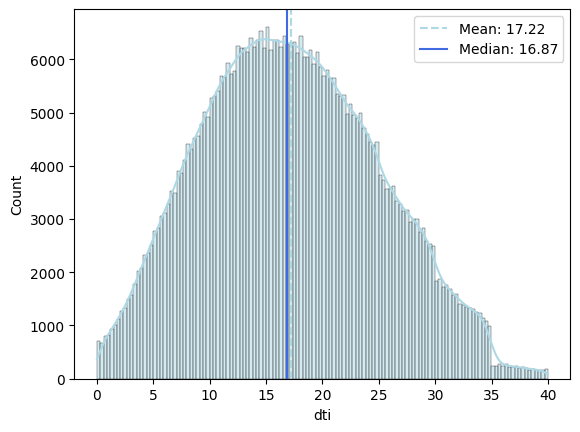

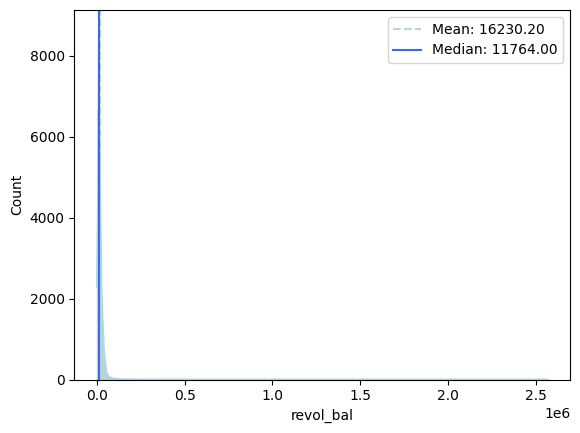

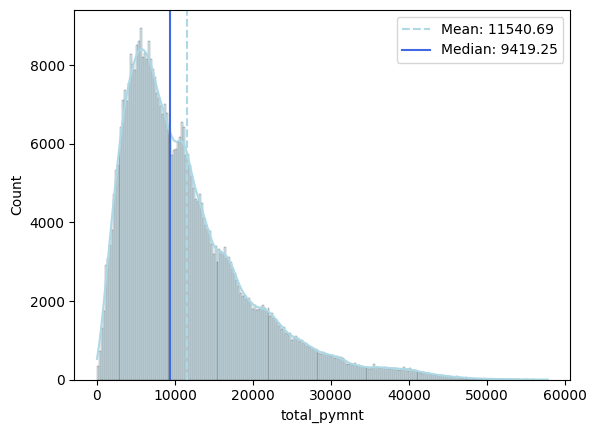

In [24]:
for i in num:
    sns.histplot(data=df, x=i, kde=True, color='lightblue')
    mean_value = df[i].mean()
    plt.axvline(mean_value, color='lightblue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    median_value = df[i].median()
    plt.axvline(median_value, color='royalblue', linestyle='-', label=f'Median: {median_value:.2f}')
    
    plt.legend()
    plt.show()

# Bivariate Analysis

In [25]:
filt_data['term'] = filt_data['term'].str.strip()

C:\Users\rofik\AppData\Local\Temp\ipykernel_25536\1232618266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_data['term'] = filt_data['term'].str.strip()


## Bivariate Fitur Kategorik

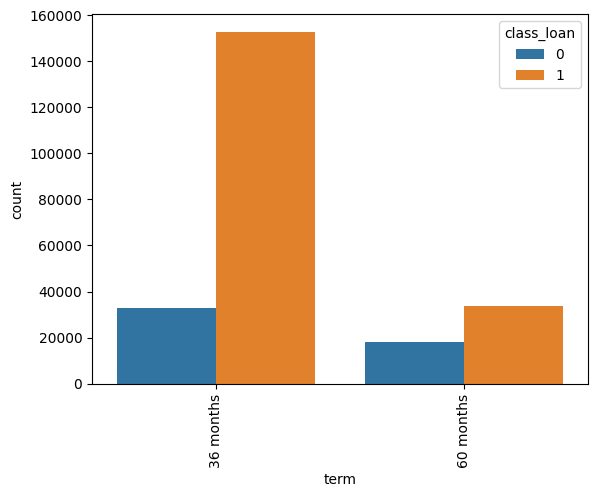

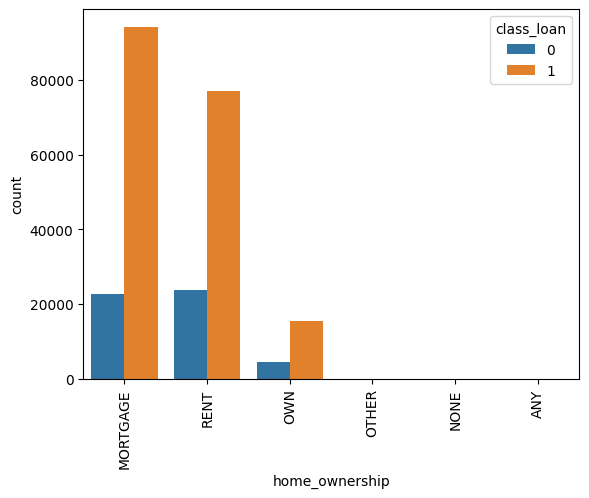

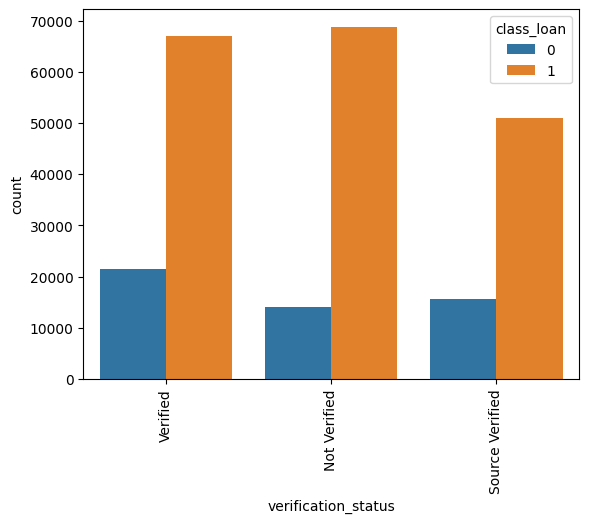

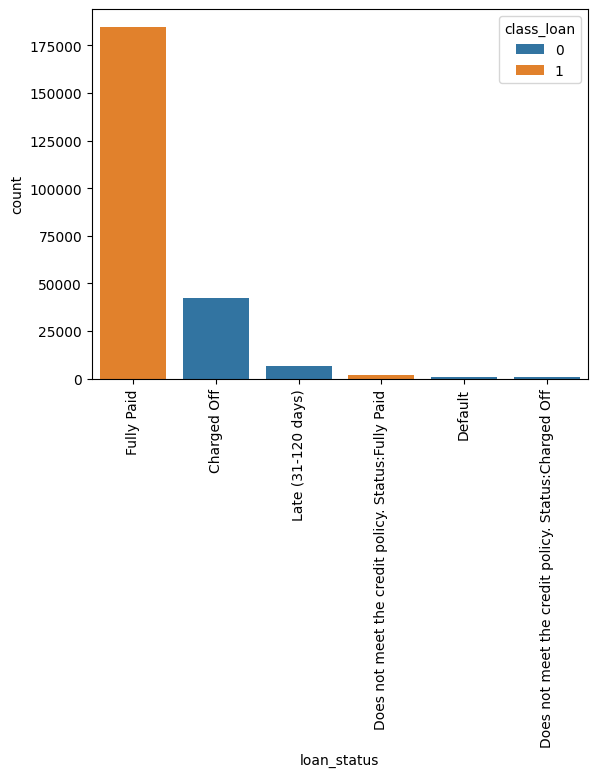

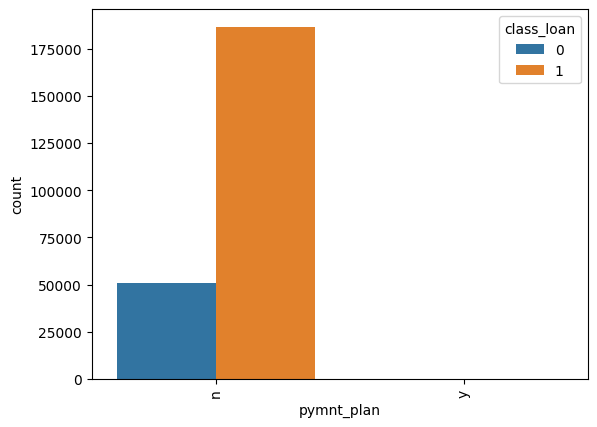

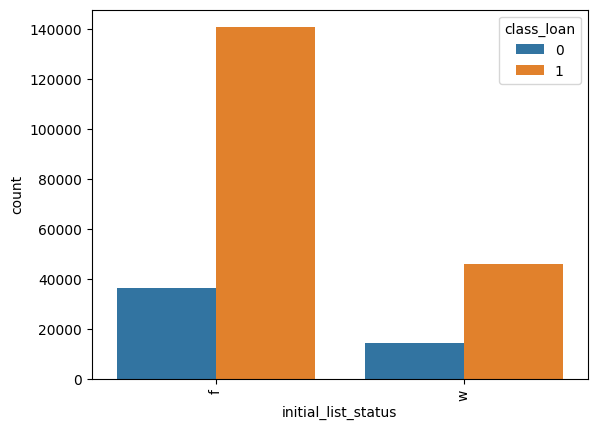

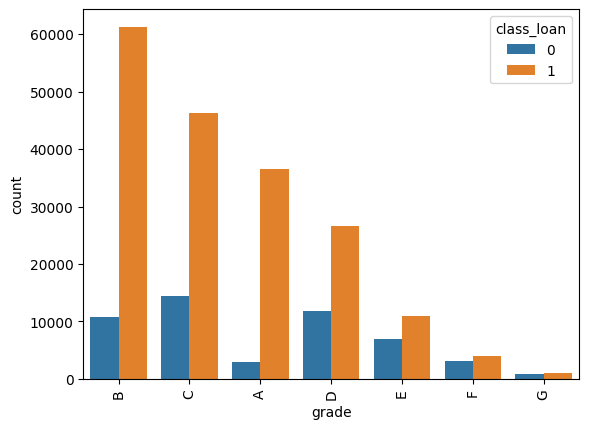

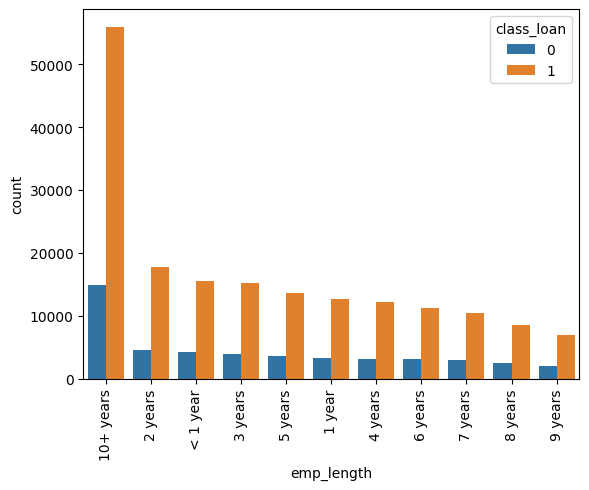

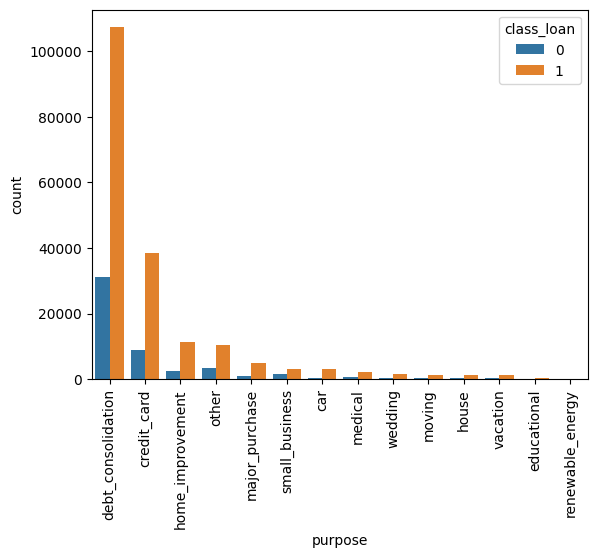

In [26]:
for i in cat:
    order = filt_data[i].value_counts().index
    sns.countplot(data=filt_data, x=i, order=order, hue='class_loan')
    plt.xticks(rotation=90)
    plt.show()

## Bivariate Fitur Numerik

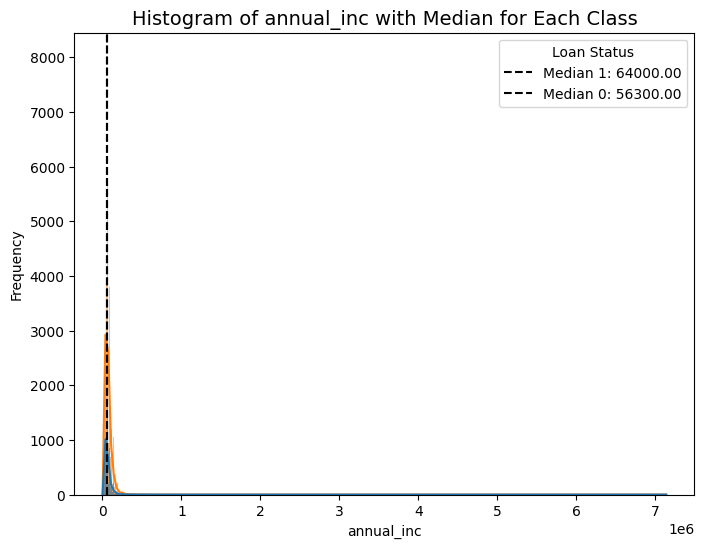

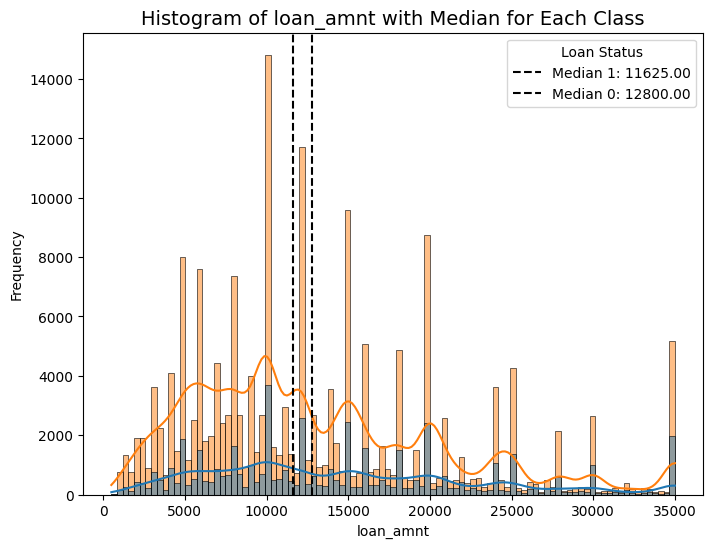

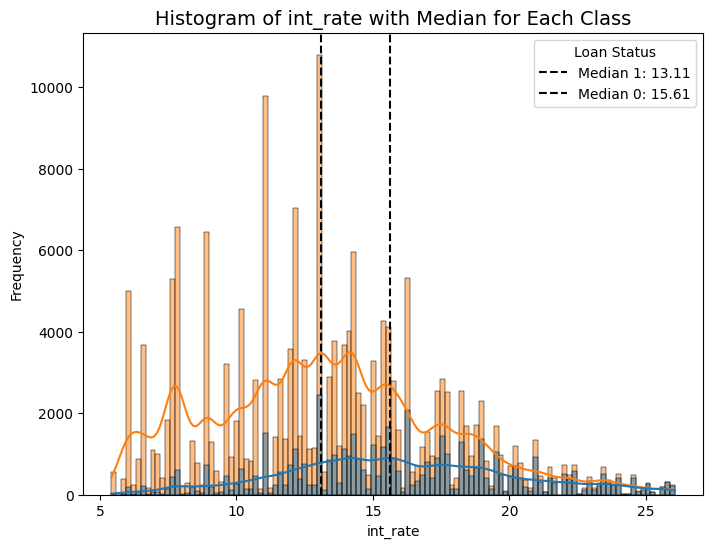

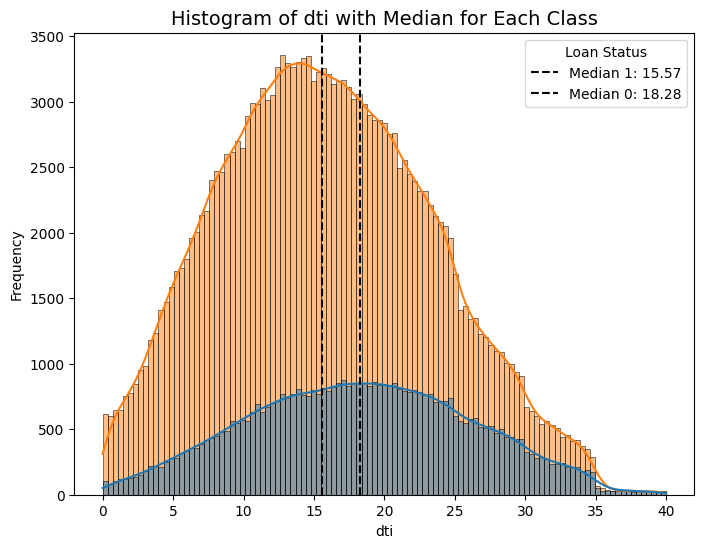

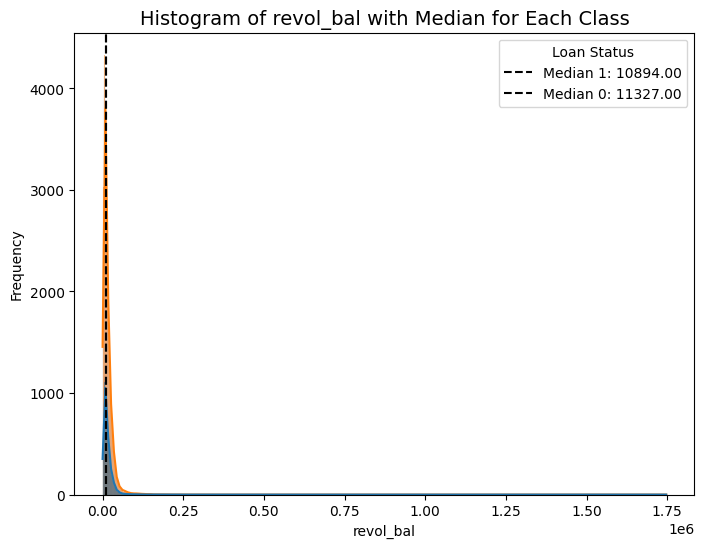

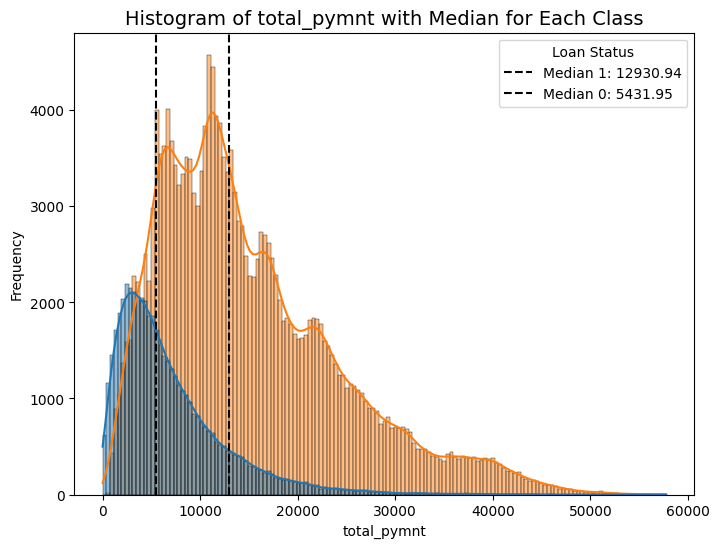

In [27]:
for i in num:
    plt.figure(figsize=(8,6))
    sns.histplot(data=filt_data, x=i, hue='class_loan', kde=True)
    for class_value in filt_data['class_loan'].unique():
        class_data = filt_data[filt_data['class_loan']==class_value]
        median_value = class_data[i].median()
        plt.axvline(median_value, color='black', linestyle='--', label=f'Median {class_value}: {median_value:.2f}')
    plt.title(f'Histogram of {i} with Median for Each Class', fontsize=14)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.legend(title='Loan Status', loc='upper right') 
    plt.show()

C:\Users\rofik\AppData\Local\Temp\ipykernel_25536\2620852675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_data['issue_d'] = pd.to_datetime(filt_data['issue_d'])
C:\Users\rofik\AppData\Local\Temp\ipykernel_25536\2620852675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_loan['year'] = bad_loan['issue_d'].dt.year


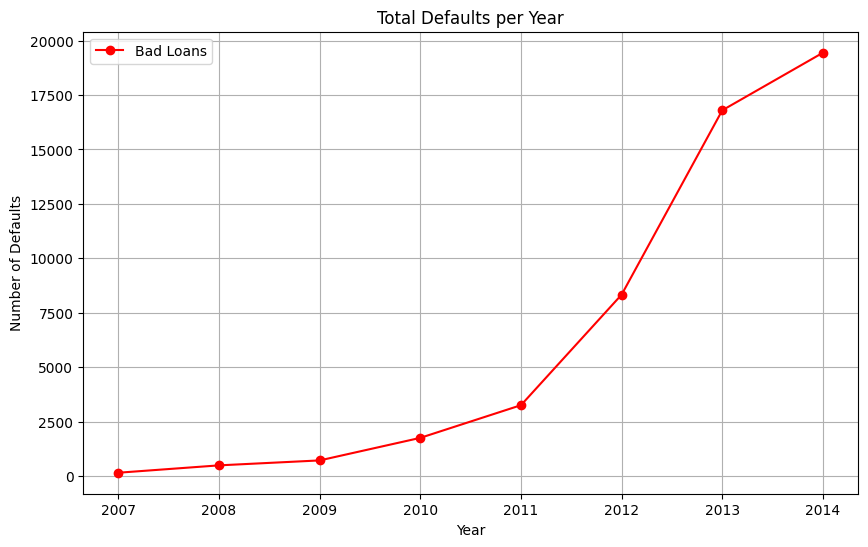

In [28]:
filt_data['issue_d'] = pd.to_datetime(filt_data['issue_d'])

bad_loan = filt_data[filt_data['class_loan'] == 0]
bad_loan['year'] = bad_loan['issue_d'].dt.year
failures_per_year = bad_loan.groupby('year').size()
plt.figure(figsize=(10,6))
plt.plot(failures_per_year.index, failures_per_year.values, marker='o', color='r', label='Bad Loans')
plt.title('Total Defaults per Year')
plt.xlabel('Year')
plt.ylabel('Number of Defaults')
plt.legend()
plt.grid(True)
plt.show()

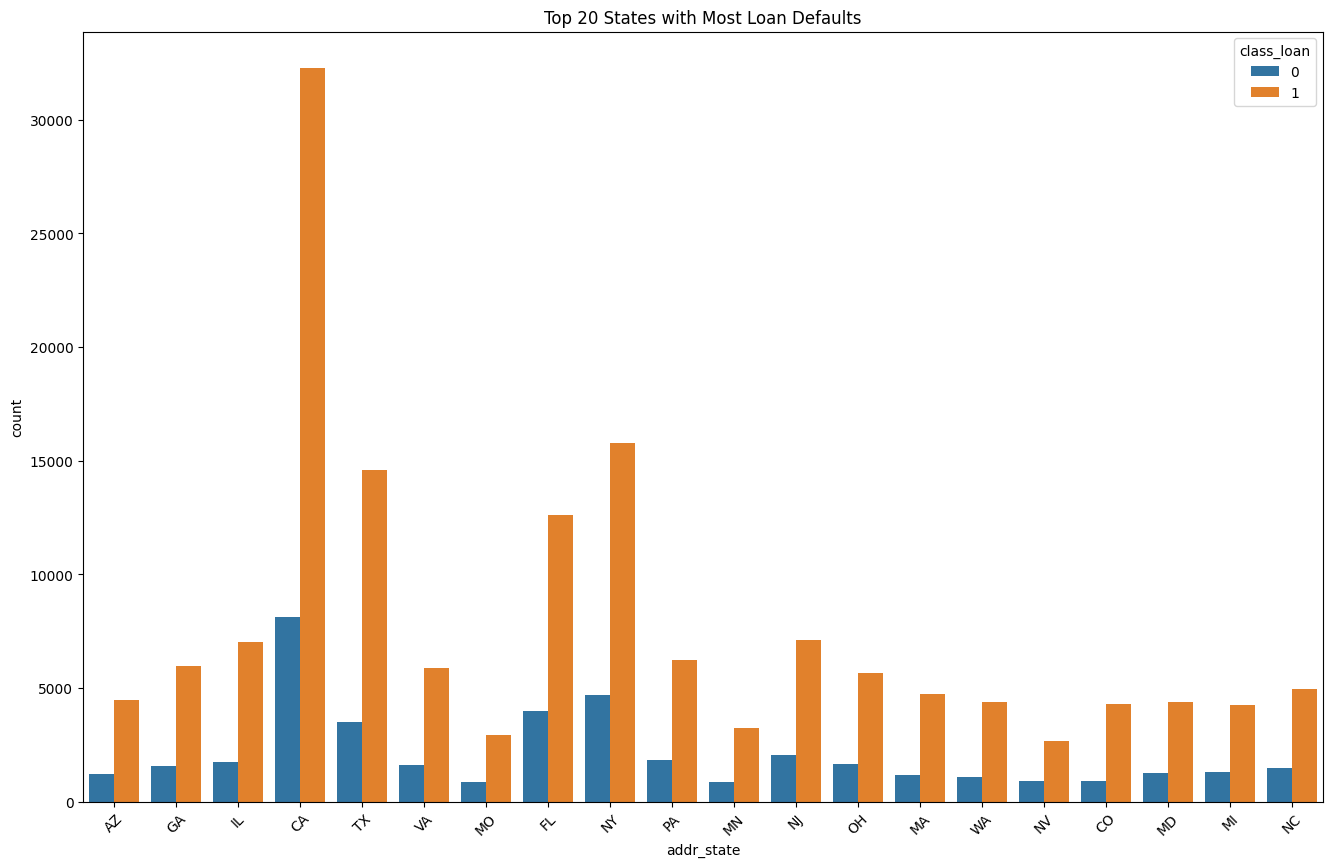

In [29]:
top_20_states = filt_data.groupby('addr_state')['class_loan'].value_counts().unstack().fillna(0)
top_20_states['total'] = top_20_states.sum(axis=1)
top_20_states = top_20_states.sort_values('total', ascending=False).head(20)
plt.figure(figsize=(16, 10))
sns.countplot(data=filt_data[filt_data['addr_state'].isin(top_20_states.index)], x='addr_state', hue='class_loan')
plt.xticks(rotation=45)
plt.title('Top 20 States with Most Loan Defaults')
plt.show()

In [30]:
filt_data = filt_data.drop(columns=['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d', 'addr_state'])

# Multivariate Analysis

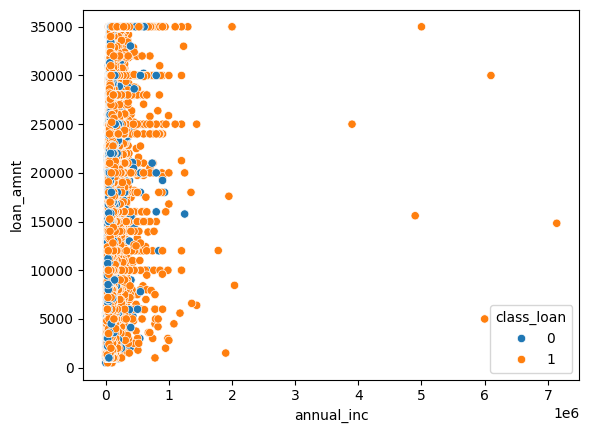

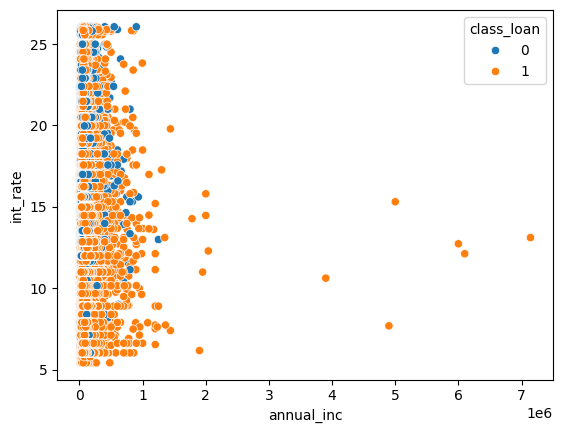

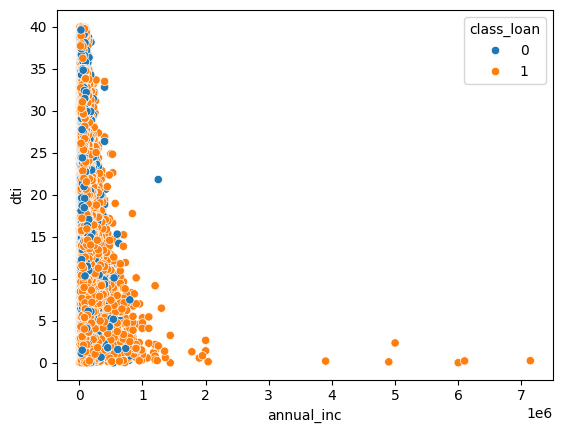

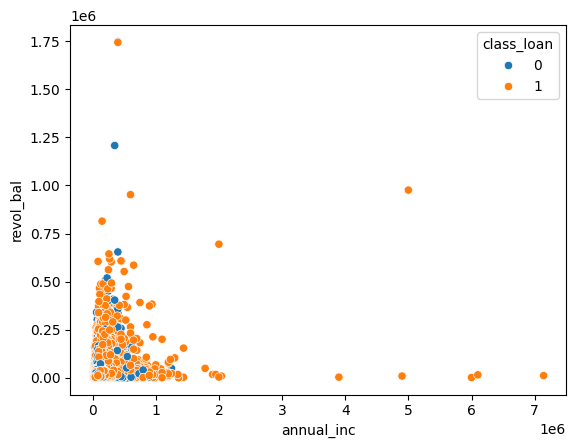

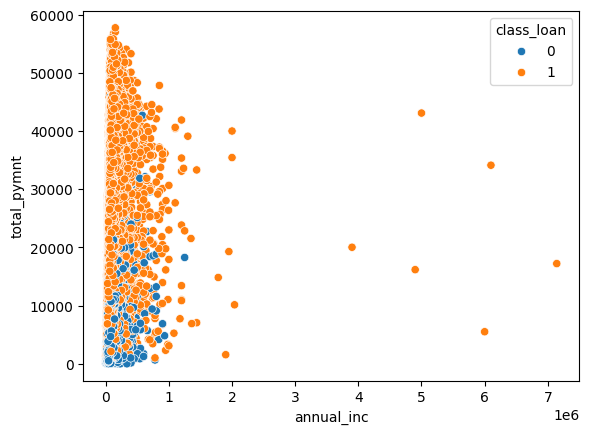

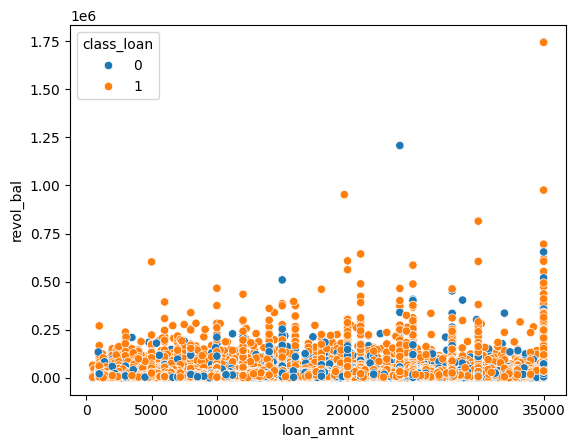

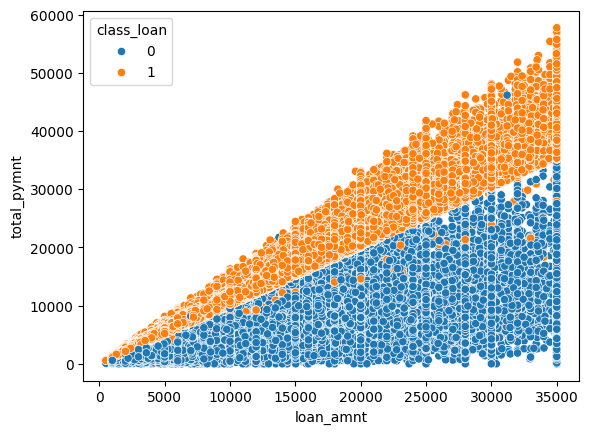

C:\Users\rofik\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


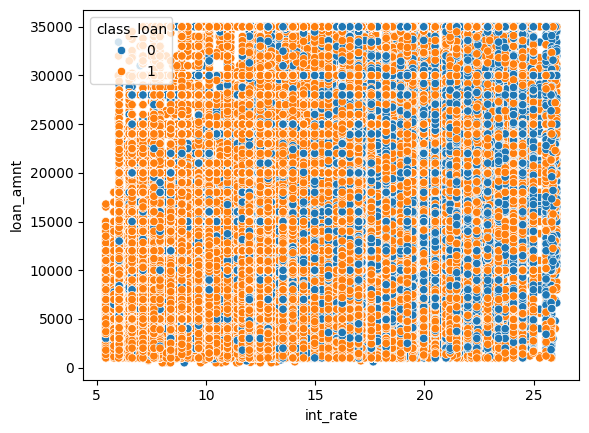

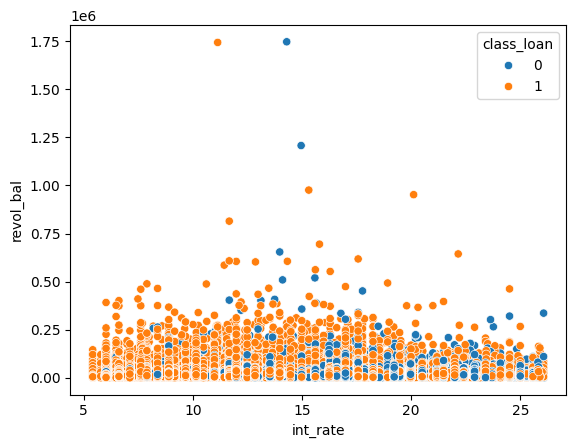

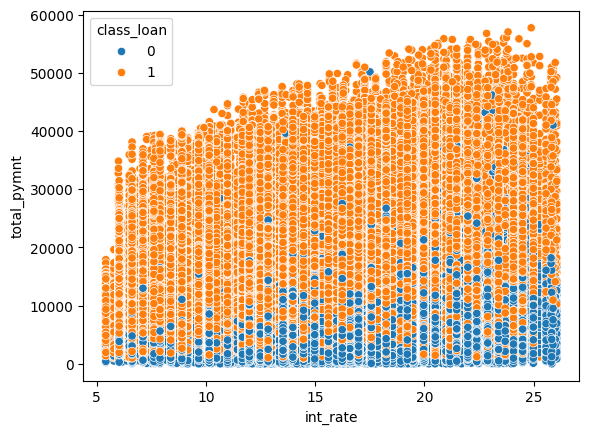

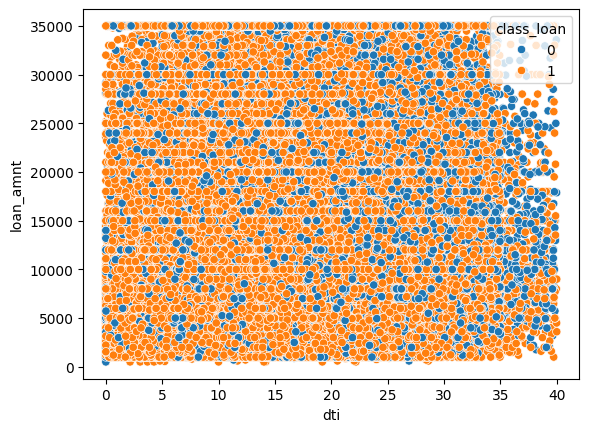

C:\Users\rofik\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


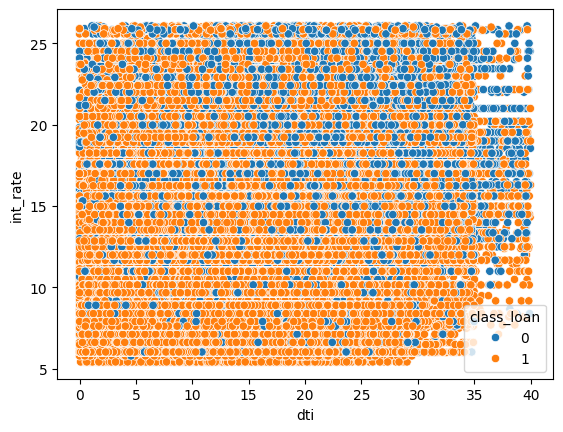

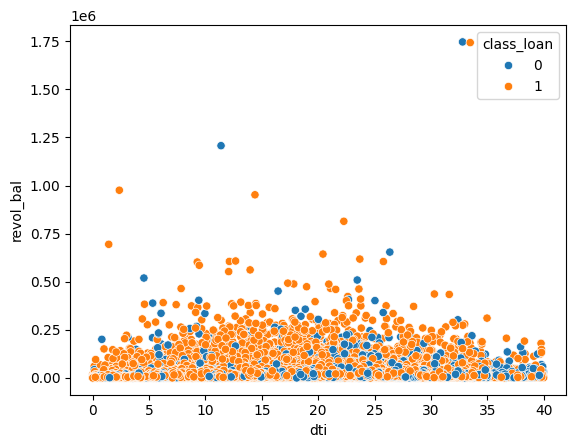

C:\Users\rofik\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


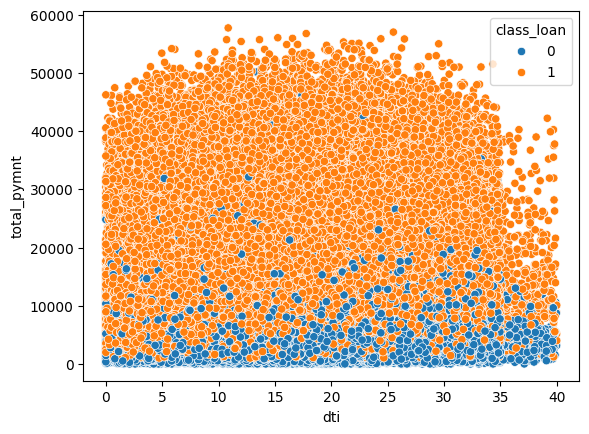

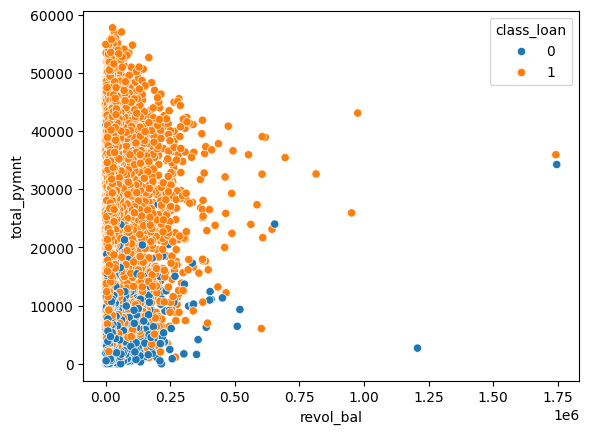

In [31]:
for i in num:
    for j in num:
        if i!=j and (i < j):
            sns.scatterplot(data=filt_data, x=i, y=j, hue='class_loan')
            plt.show()

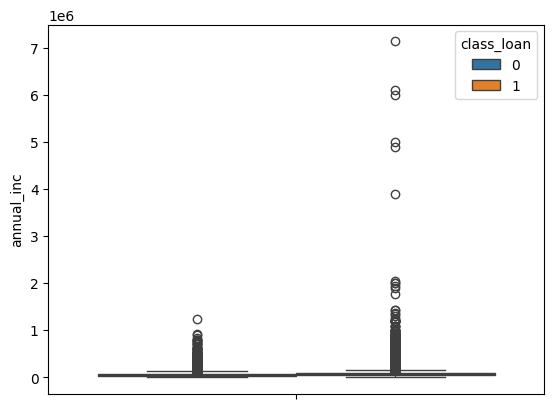

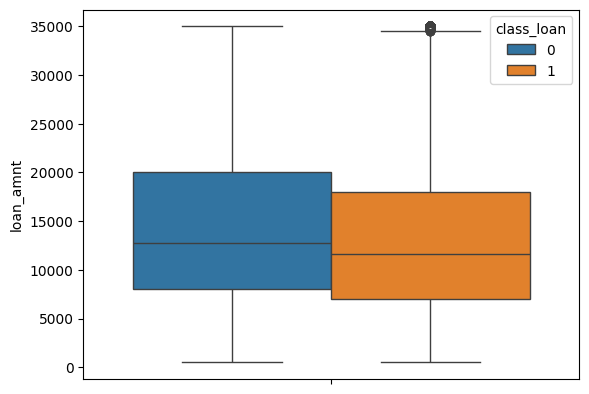

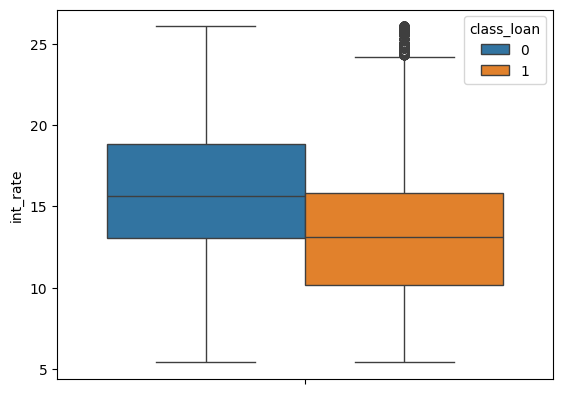

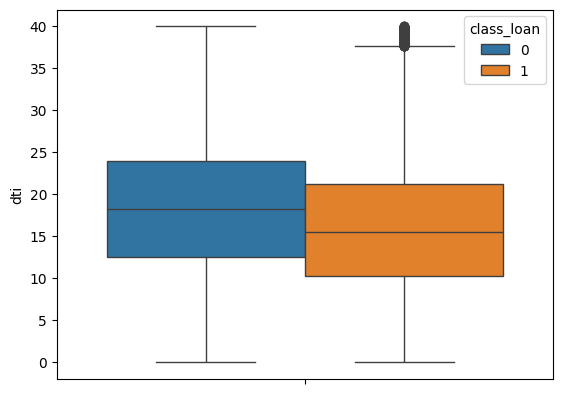

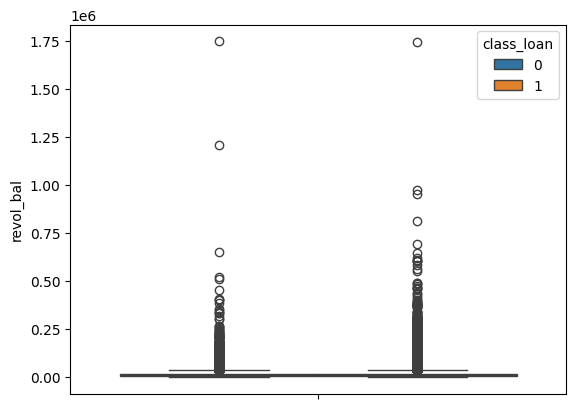

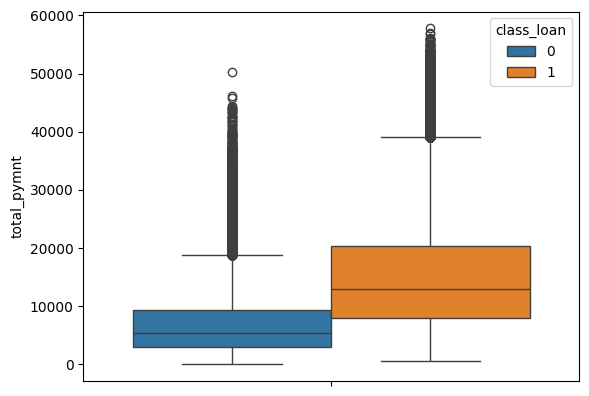

In [32]:
for i in num:
    sns.boxplot(data=filt_data, y=i, hue='class_loan')
    plt.show()

In [33]:
filt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237695 entries, 0 to 466283
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        237695 non-null  object 
 1   home_ownership              237695 non-null  object 
 2   verification_status         237695 non-null  object 
 3   loan_status                 237695 non-null  object 
 4   pymnt_plan                  237695 non-null  object 
 5   purpose                     237695 non-null  object 
 6   initial_list_status         237695 non-null  object 
 7   annual_inc                  237691 non-null  float64
 8   loan_amnt                   237695 non-null  int64  
 9   int_rate                    237695 non-null  float64
 10  dti                         237695 non-null  float64
 11  revol_bal                   237695 non-null  int64  
 12  total_pymnt                 237695 non-null  float64
 13  delinq_2yrs        

In [34]:
filt_data.columns

Index(['term', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'annual_inc',
       'loan_amnt', 'int_rate', 'dti', 'revol_bal', 'total_pymnt',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'grade', 'emp_length', 'payment_time', 'loan_time', 'class_loan'],
      dtype='object')

# Data Cleaning

In [35]:
null = filt_data.isnull().sum()
null

term                             0
home_ownership                   0
verification_status              0
loan_status                      0
pymnt_plan                       0
purpose                          0
initial_list_status              0
annual_inc                       4
loan_amnt                        0
int_rate                         0
dti                              0
revol_bal                        0
total_pymnt                      0
delinq_2yrs                     29
inq_last_6mths                  29
open_acc                        29
pub_rec                         29
revol_util                     231
total_acc                       29
out_prncp                        0
total_rec_prncp                  0
total_rec_int                    0
total_rec_late_fee               0
recoveries                       0
collection_recovery_fee          0
last_pymnt_amnt                  0
collections_12_mths_ex_med     145
acc_now_delinq                  29
grade               

In [36]:
null_percentage = (filt_data.isnull().sum()/len(filt_data)) * 100
sort_null = null_percentage.sort_values(ascending=False)
sort_null

emp_length                    3.851995
payment_time                  0.158186
revol_util                    0.097183
collections_12_mths_ex_med    0.061003
loan_time                     0.021456
pub_rec                       0.012201
delinq_2yrs                   0.012201
open_acc                      0.012201
inq_last_6mths                0.012201
total_acc                     0.012201
acc_now_delinq                0.012201
annual_inc                    0.001683
collection_recovery_fee       0.000000
recoveries                    0.000000
total_rec_late_fee            0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
grade                         0.000000
last_pymnt_amnt               0.000000
term                          0.000000
out_prncp                     0.000000
home_ownership                0.000000
total_pymnt                   0.000000
revol_bal                     0.000000
dti                           0.000000
int_rate                 

In [37]:
filt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237695 entries, 0 to 466283
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        237695 non-null  object 
 1   home_ownership              237695 non-null  object 
 2   verification_status         237695 non-null  object 
 3   loan_status                 237695 non-null  object 
 4   pymnt_plan                  237695 non-null  object 
 5   purpose                     237695 non-null  object 
 6   initial_list_status         237695 non-null  object 
 7   annual_inc                  237691 non-null  float64
 8   loan_amnt                   237695 non-null  int64  
 9   int_rate                    237695 non-null  float64
 10  dti                         237695 non-null  float64
 11  revol_bal                   237695 non-null  int64  
 12  total_pymnt                 237695 non-null  float64
 13  delinq_2yrs        

In [38]:
num = filt_data.select_dtypes(include=['int', 'float64'])
obj = filt_data.select_dtypes(include=['object'])

<Axes: >

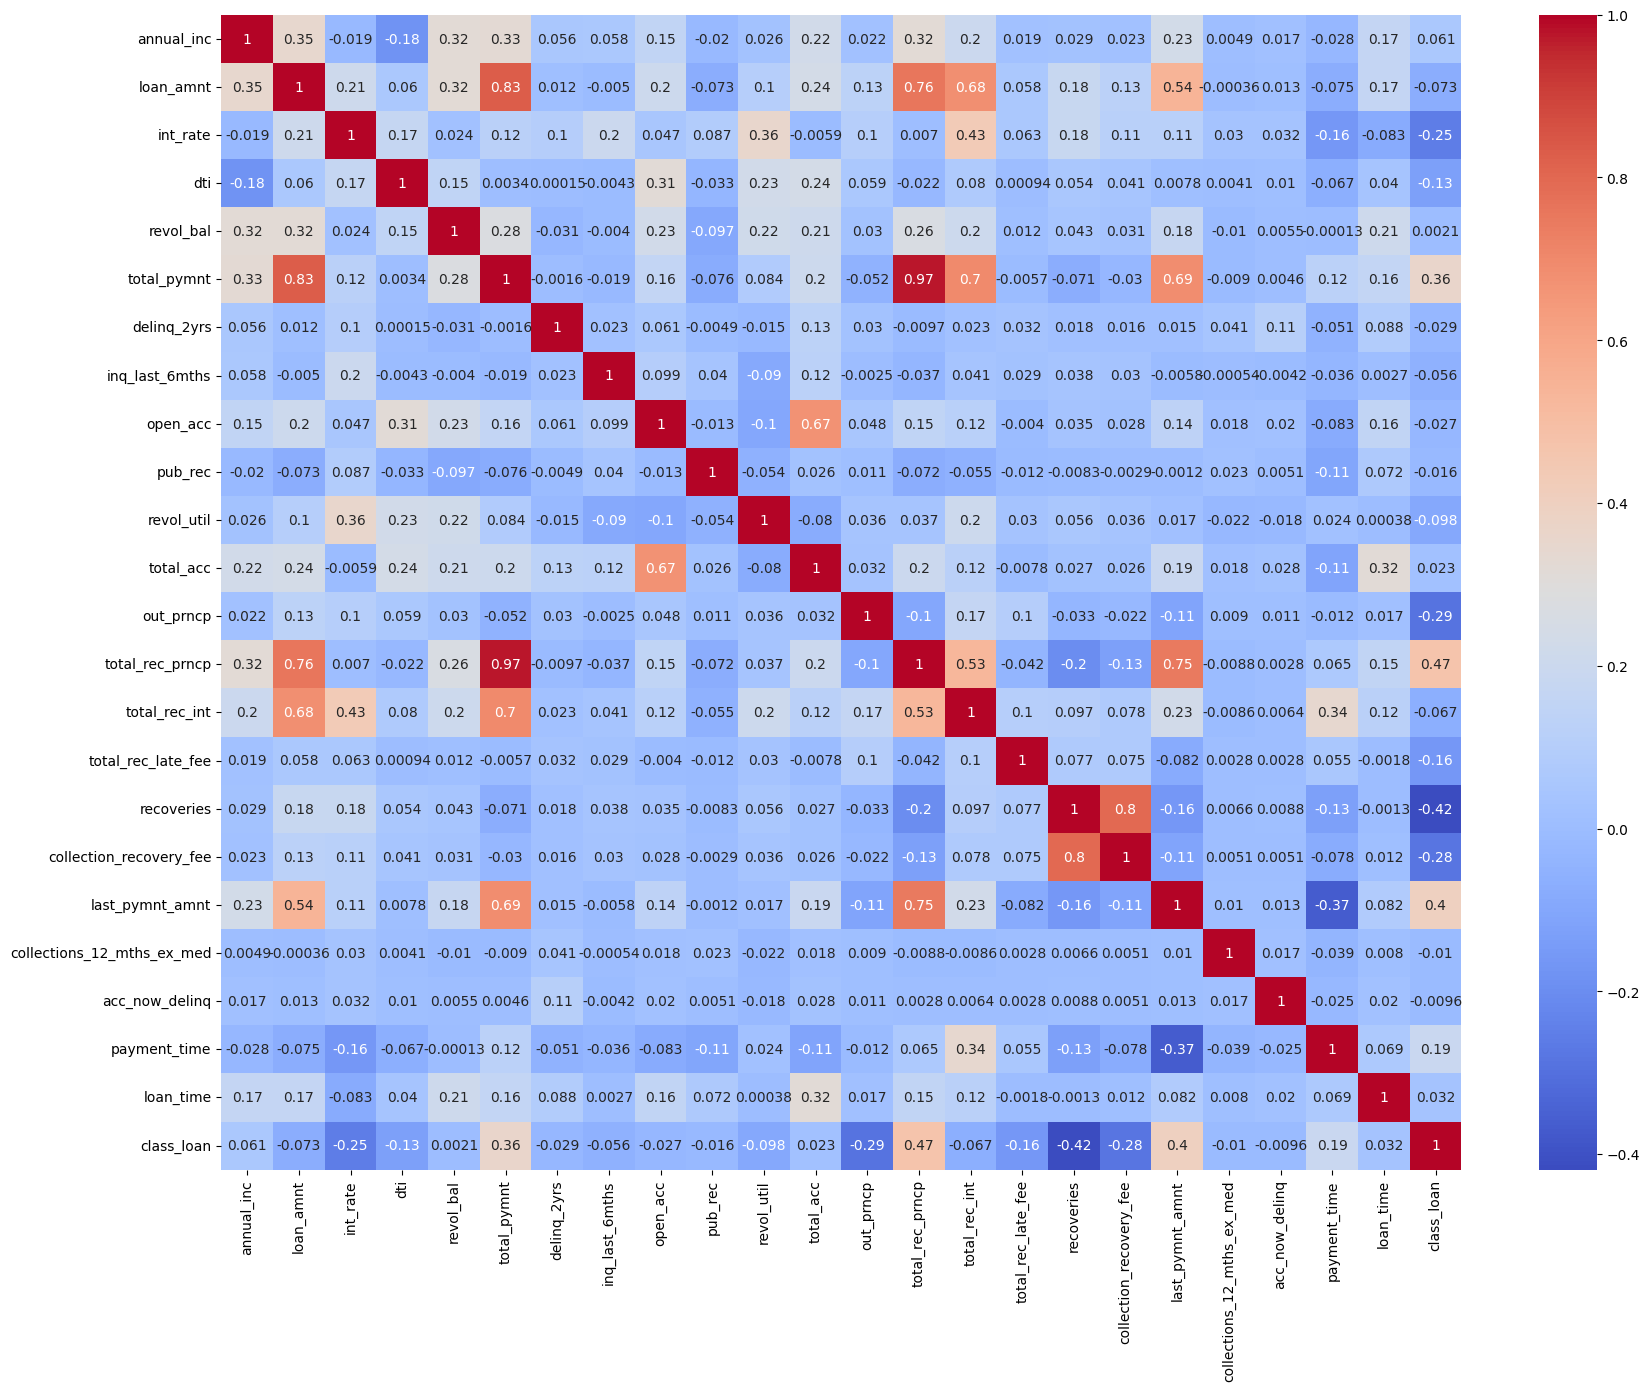

In [39]:
plt.figure(figsize=(20,15))
sns.heatmap(num.corr(), annot=True, cmap='coolwarm')

In [40]:
ob= filt_data.select_dtypes(include='object')
ob

term home_ownership verification_status  loan_status pymnt_plan  \
0       36 months           RENT            Verified   Fully Paid          n   
1       60 months           RENT     Source Verified  Charged Off          n   
2       36 months           RENT        Not Verified   Fully Paid          n   
3       36 months           RENT     Source Verified   Fully Paid          n   
5       36 months           RENT     Source Verified   Fully Paid          n   
...           ...            ...                 ...          ...        ...   
466276  60 months       MORTGAGE            Verified  Charged Off          n   
466277  36 months           RENT            Verified  Charged Off          n   
466278  36 months           RENT     Source Verified   Fully Paid          n   
466281  60 months       MORTGAGE            Verified  Charged Off          n   
466283  36 months            OWN            Verified   Fully Paid          n   

                   purpose initial_list_status grade emp_length  
0              credit_card                   f     B  10+ years  
1                      car                   f     C   < 1 year  
2           small_business                   f     C  10+ years  
3                    other                   f     C  10+ years  
5                  wedding                   f     A    3 years  
...                    ...                 ...   ...        ...  
466276             medical                   f     D    5 years  
466277  debt_consolidation                   f     A    3 years  
466278            vacation                   f     D  10+ years  
466281  debt_consolidation                   f     D  10+ years  
466283         credit_card                   w     A    3 years  

[237695 rows x 9 columns]

In [41]:
filt_data.columns

Index(['term', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'annual_inc',
       'loan_amnt', 'int_rate', 'dti', 'revol_bal', 'total_pymnt',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'grade', 'emp_length', 'payment_time', 'loan_time', 'class_loan'],
      dtype='object')

## Encoding

In [42]:
filt_data = filt_data.dropna()

In [43]:
filt_data.isnull().sum()

term                          0
home_ownership                0
verification_status           0
loan_status                   0
pymnt_plan                    0
purpose                       0
initial_list_status           0
annual_inc                    0
loan_amnt                     0
int_rate                      0
dti                           0
revol_bal                     0
total_pymnt                   0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
out_prncp                     0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
acc_now_delinq                0
grade                         0
emp_length                    0
payment_time                  0
loan_tim

In [44]:
print(filt_data[['term', 'home_ownership', 'grade', 'pymnt_plan']].isna().sum())


term              0
home_ownership    0
grade             0
pymnt_plan        0
dtype: int64


In [45]:
filt_data[['term', 'home_ownership', 'grade', 'pymnt_plan']].describe()

term home_ownership   grade pymnt_plan
count      227835         227835  227835     227835
unique          2              6       7          2
top     36 months       MORTGAGE       B          n
freq       177238         112296   69071     227829

In [46]:
filt_data['term'].unique()

array(['36 months', '60 months'], dtype=object)

In [47]:
filt_data['term'] = filt_data['term'].str.strip()

In [48]:
filt_data['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [49]:
filt_data['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [50]:
filt_data['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [51]:
term_mapping = {'36 months': 0, '60 months': 1}
home_ownership_mapping = {'OTHER': 0, 'NONE': 0, 'ANY': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
pymnt_plan_mapping = {'n': 1, 'y': 0}

# Pastikan tidak ada spasi tersembunyi
filt_data['term'] = filt_data['term'].str.strip()
filt_data['home_ownership'] = filt_data['home_ownership'].str.strip()
filt_data['grade'] = filt_data['grade'].str.strip()
filt_data['pymnt_plan'] = filt_data['pymnt_plan'].str.strip()

# Mapping data dengan handling NaN
filt_data['term'] = filt_data['term'].map(term_mapping).fillna(-1).astype(int)
filt_data['home_ownership'] = filt_data['home_ownership'].map(home_ownership_mapping).fillna(-1).astype(int)
filt_data['grade'] = filt_data['grade'].map(grade_mapping).fillna(-1).astype(int)
filt_data['pymnt_plan'] = filt_data['pymnt_plan'].map(pymnt_plan_mapping).fillna(-1).astype(int)

# Validasi hasil mapping
print(filt_data[['term', 'home_ownership', 'grade', 'pymnt_plan']].head())

   term  home_ownership  grade  pymnt_plan
0     0               1      5           1
1     1               1      4           1
2     0               1      4           1
3     0               1      4           1
5     0               1      6           1


In [52]:
filt_data.columns

Index(['term', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'annual_inc',
       'loan_amnt', 'int_rate', 'dti', 'revol_bal', 'total_pymnt',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'grade', 'emp_length', 'payment_time', 'loan_time', 'class_loan'],
      dtype='object')

In [53]:
ob= filt_data.select_dtypes(include='object')
ob

verification_status  loan_status             purpose  \
0                 Verified   Fully Paid         credit_card   
1          Source Verified  Charged Off                 car   
2             Not Verified   Fully Paid      small_business   
3          Source Verified   Fully Paid               other   
5          Source Verified   Fully Paid             wedding   
...                    ...          ...                 ...   
466276            Verified  Charged Off             medical   
466277            Verified  Charged Off  debt_consolidation   
466278     Source Verified   Fully Paid            vacation   
466281            Verified  Charged Off  debt_consolidation   
466283            Verified   Fully Paid         credit_card   

       initial_list_status emp_length  
0                        f  10+ years  
1                        f   < 1 year  
2                        f  10+ years  
3                        f  10+ years  
5                        f    3 years  
...                    ...        ...  
466276                   f    5 years  
466277                   f    3 years  
466278                   f  10+ years  
466281                   f  10+ years  
466283                   w    3 years  

[227835 rows x 5 columns]

## Drop Multikolionaritas

In [54]:
filt_data = filt_data.drop(columns=['verification_status','emp_length','loan_status', 'purpose','initial_list_status', 'grade', 'total_rec_int', 'last_pymnt_amnt', 'collection_recovery_fee', 'total_acc', 'total_pymnt', 'loan_amnt'])

In [55]:
filt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227835 entries, 0 to 466283
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        227835 non-null  int32  
 1   home_ownership              227835 non-null  int32  
 2   pymnt_plan                  227835 non-null  int32  
 3   annual_inc                  227835 non-null  float64
 4   int_rate                    227835 non-null  float64
 5   dti                         227835 non-null  float64
 6   revol_bal                   227835 non-null  int64  
 7   delinq_2yrs                 227835 non-null  float64
 8   inq_last_6mths              227835 non-null  float64
 9   open_acc                    227835 non-null  float64
 10  pub_rec                     227835 non-null  float64
 11  revol_util                  227835 non-null  float64
 12  out_prncp                   227835 non-null  float64
 13  total_rec_prncp    

## Heatmap

<Axes: >

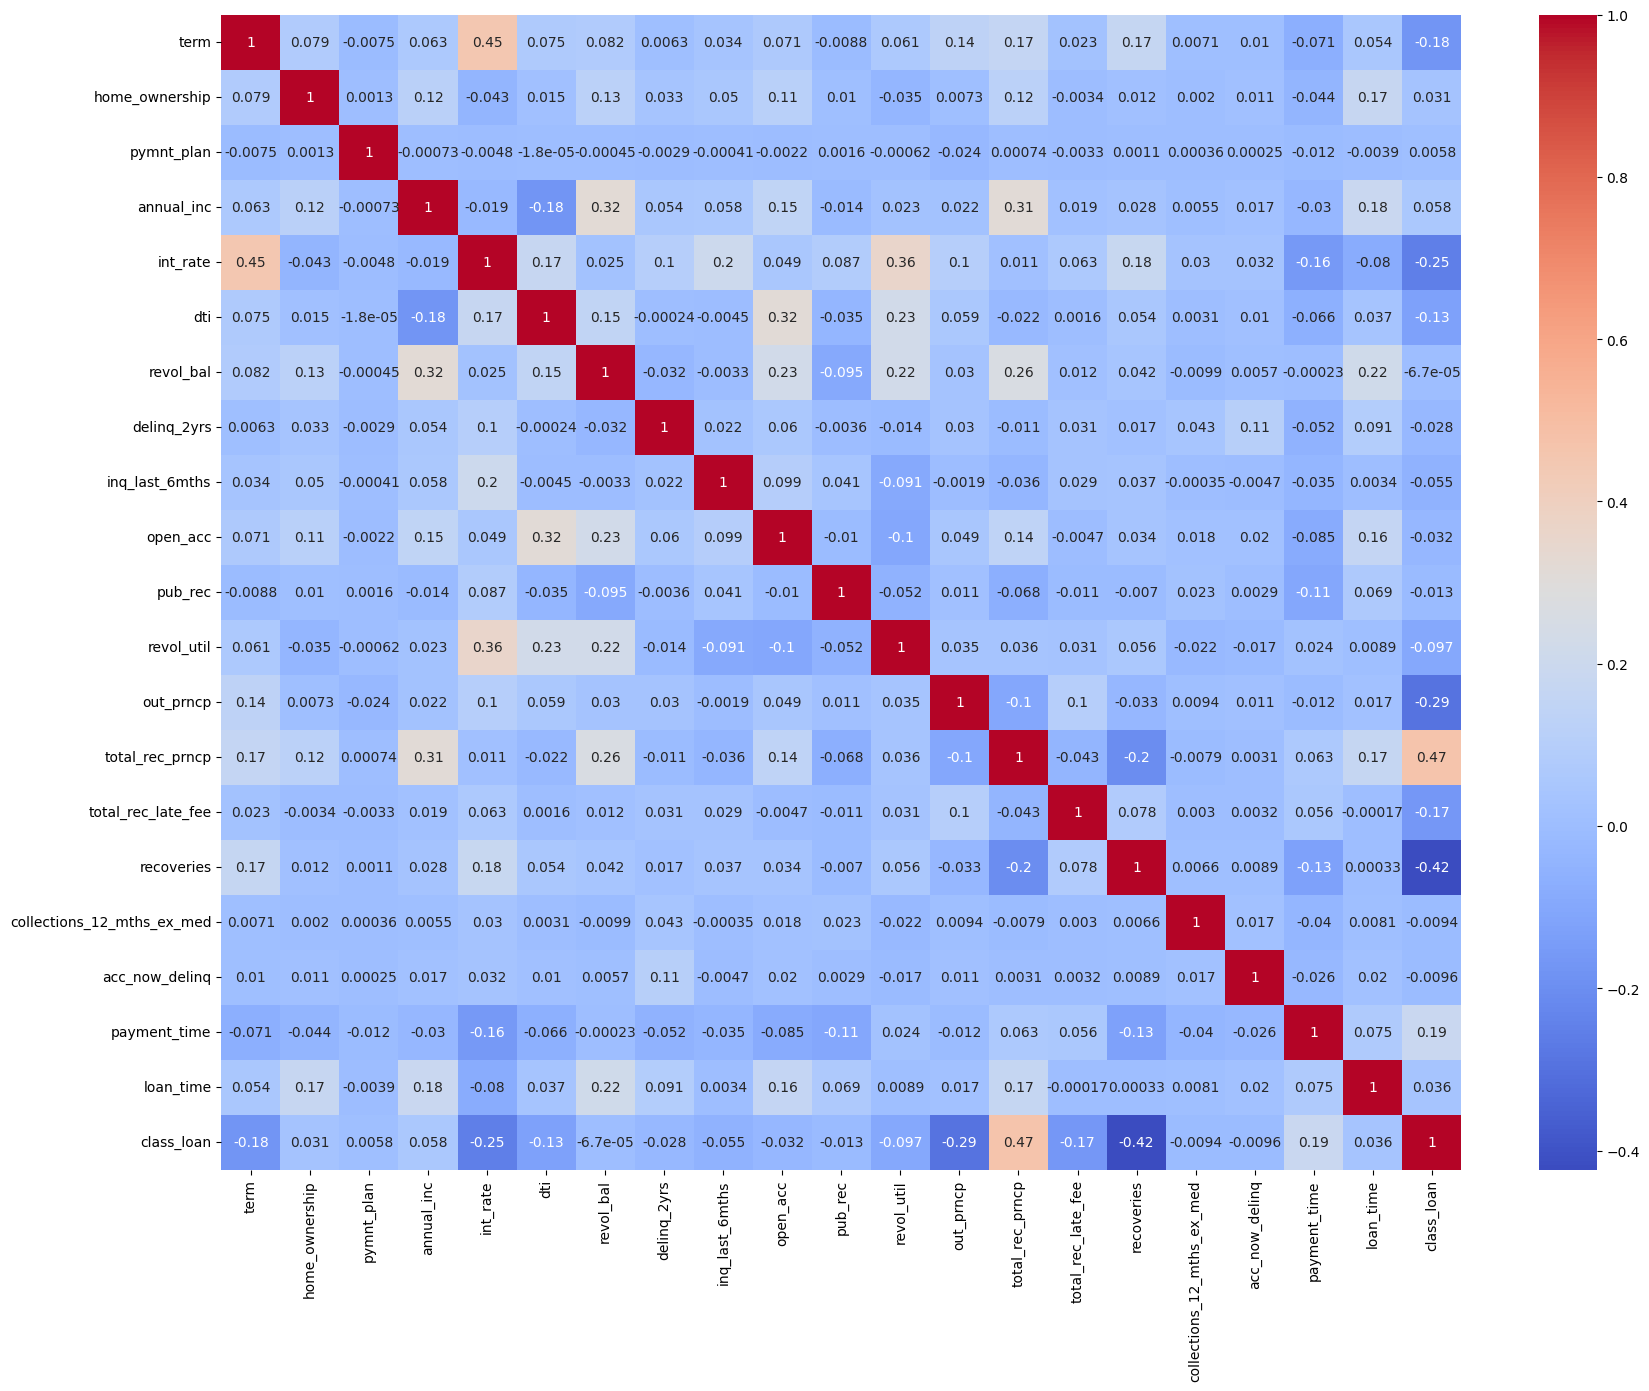

In [56]:
plt.figure(figsize=(20,15))
sns.heatmap(filt_data.corr(), annot=True, cmap='coolwarm')

# Modelling

In [57]:
X = filt_data.drop(columns=['class_loan'])
y = filt_data['class_loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print(f"Accuracy (Test Set): {accuracy_score(y_test, y_pred):.3f}")
    print(f"Accuracy (Train Set): {accuracy_score(y_train, y_pred_train):.3f}")
    print(f"Precision (Test Set): {precision_score(y_test, y_pred):.3f}")
    print(f"Precision (Train Set): {precision_score(y_train, y_pred_train):.3f}")
    print(f"Recall (Test Set): {recall_score(y_test, y_pred):.3f}")
    print(f"Recall (Train Set): {recall_score(y_train, y_pred_train):.3f}")
    print(f"F1-Score (Test Set): {f1_score(y_test, y_pred):.3f}")
    print(f"F1-Score (Train Set): {f1_score(y_train, y_pred_train):.3f}")
    print(f"ROC AUC (Test Set): {roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
    print(f"ROC AUC (Train Set): {roc_auc_score(y_train, y_pred_proba_train[:, 1]):.3f}")

    score = cross_validate(model, X, y, cv=5, scoring='recall', return_train_score=True)
    print(f"Recall (Crossval Train): {score['train_score'].mean():.3f}")
    print(f"Recall (Crossval Test): {score['test_score'].mean():.3f}")

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')
    plt.show()

def show_best_hyperparameter(model):
    params = model.best_estimator_.get_params()
    for param, value in params.items():
        if isinstance(value, float):
            print(f"{param}: {value:.3f}")
        else:
            print(f"{param}: {value}")

In [59]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
eval_classification(xgb)

Accuracy (Test Set): 0.971
Accuracy (Train Set): 0.978
Precision (Test Set): 0.976
Precision (Train Set): 0.979
Recall (Test Set): 0.988
Recall (Train Set): 0.992
F1-Score (Test Set): 0.982
F1-Score (Train Set): 0.986
ROC AUC (Test Set): 0.993
ROC AUC (Train Set): 0.997
Recall (Crossval Train): 0.993
Recall (Crossval Test): 0.988


In [60]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
eval_classification(logreg)

c:\Users\rofik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Test Set): 0.948
Accuracy (Train Set): 0.949
Precision (Test Set): 0.954
Precision (Train Set): 0.953
Recall (Test Set): 0.982
Recall (Train Set): 0.983
F1-Score (Test Set): 0.968
F1-Score (Train Set): 0.968
ROC AUC (Test Set): 0.973
ROC AUC (Train Set): 0.973


c:\Users\rofik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rofik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Recall (Crossval Train): 0.983
Recall (Crossval Test): 0.984


## Tuning Parameter

In [61]:
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 150],               # Jumlah pohon yang moderat
    'max_depth': [6, 7],                       # Kedalaman pohon moderat
    'learning_rate': [0.05, 0.1],              # Learning rate moderat
    'min_child_weight': [5, 10],                # Nilai moderat untuk menghindari overfitting
    'subsample': [0.8],                        # Menggunakan sebagian data
    'colsample_bytree': [0.8],                 # Menggunakan sebagian fitur
    'gamma': [0, 0.1]                          # Mengatur pembelahan pohon lebih lanjut
}

xgb_model = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='precision', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

xgb_best = grid_search.best_estimator_
xgb_best.fit(X_train, y_train)
eval_classification(xgb_best)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.8}
Accuracy (Test Set): 0.971
Accuracy (Train Set): 0.974
Precision (Test Set): 0.974
Precision (Train Set): 0.976
Recall (Test Set): 0.989
Recall (Train Set): 0.992
F1-Score (Test Set): 0.982
F1-Score (Train Set): 0.984
ROC AUC (Test Set): 0.993
ROC AUC (Train Set): 0.995
Recall (Crossval Train): 0.992
Recall (Crossval Test): 0.989


In [62]:
param_grid = {
    'C': [0.01, 1, 100],  # Regularization strength
    'solver': ['liblinear'],  # Single solver
    'penalty': ['l2'],  # Single penalization term
    'max_iter': [100],  # Single iteration count
}

logreg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid,
                           scoring='precision', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

logreg_best = grid_search.best_estimator_
logreg_best.fit(X_train, y_train)
eval_classification(logreg_best)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found:  {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy (Test Set): 0.944
Accuracy (Train Set): 0.944
Precision (Test Set): 0.947
Precision (Train Set): 0.947
Recall (Test Set): 0.985
Recall (Train Set): 0.985
F1-Score (Test Set): 0.965
F1-Score (Train Set): 0.966
ROC AUC (Test Set): 0.970
ROC AUC (Train Set): 0.969
Recall (Crossval Train): 0.984
Recall (Crossval Test): 0.982


In [63]:
y_pred = xgb_best.predict(X_test)

In [64]:

cm = confusion_matrix(y_test, y_pred)

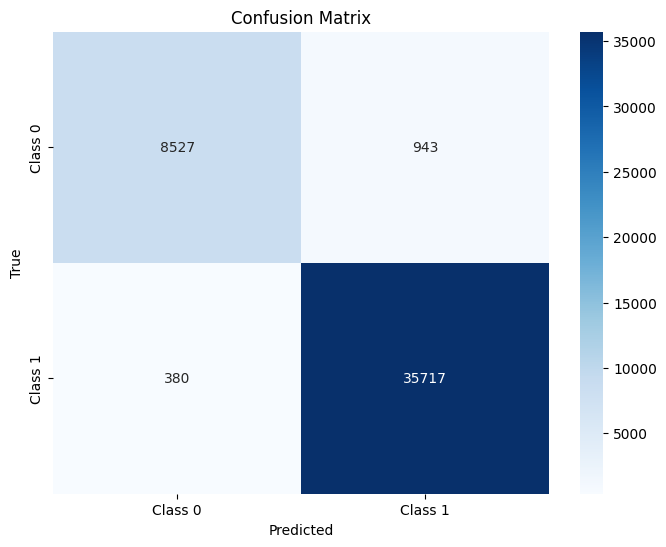

In [65]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

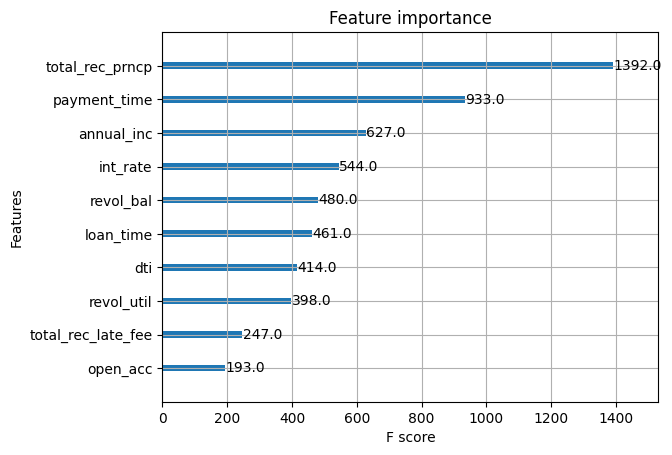

In [66]:
xgb.plot_importance(xgb_best, importance_type='weight', max_num_features=10)
plt.show()

# Rekomendasi

1. Identifikasi Risiko Berdasarkan Total Pembayaran Tertunda
Data menunjukkan peminjam yang gagal bayar memiliki total pembayaran jauh lebih rendah, menunjukkan bahwa mereka berhenti membayar lebih awal.
Action: Buat sistem pemantauan untuk mendeteksi pembayaran yang tertunda pada tahap awal angsuran. Kirim pengingat atau tawarkan opsi restrukturisasi jika peminjam menunjukkan tanda keterlambatan pembayaran dalam 2–3 angsuran pertama.
2. Tingkatkan Validasi untuk Peminjam di Grade Risiko Tinggi (B, C, D)
Grade B, C, dan D menunjukkan tingkat gagal bayar yang tinggi meskipun telah melalui proses verifikasi.
Action: Tingkatkan kriteria evaluasi kredit untuk grade ini, seperti mempertimbangkan rasio DTI, saldo utang (revol_bal), dan jumlah pinjaman sebelumnya dalam keputusan pemberian pinjaman.
3. Segmentasi Berdasarkan Tujuan Pinjaman
Sebagian besar peminjam menggunakan pinjaman untuk melunasi hutang sebelumnya, tetapi kelompok ini juga mendominasi gagal bayar.
Action: Tambahkan analisis kemampuan pembayaran tambahan pada kelompok ini, dengan menilai jumlah hutang yang ingin dilunasi terhadap pendapatan tahunan dan pengeluaran mereka.
4. Penguatan Kebijakan untuk Wilayah Risiko Tinggi (CA, TX, FL, NY)
Wilayah ini memiliki jumlah pengajuan tinggi namun tingkat gagal bayar signifikan.
Action: Implementasikan kebijakan yang lebih ketat di wilayah ini, seperti menaikkan ambang batas minimum pendapatan atau menurunkan jumlah maksimum pinjaman untuk peminjam berisiko.
5. Implementasi Model XGBoost
Gunakan model XGBoost sebagai alat prediksi risiko untuk menyaring peminjam berisiko tinggi sebelum persetujuan pinjaman, terutama di grade B, C, dan D.
6. Fokus pada Fitur Utama
Prioritaskan total_rec_prncp, last_pymnt_amnt, dan total_pymnt sebagai indikator utama dalam evaluasi risiko kredit dan pemantauan pembayaran.
7. Update Model Secara Berkala
Lakukan pelatihan ulang model secara periodik untuk mengakomodasi perubahan karakteristik data atau tren baru, sehingga akurasi prediksi tetap optimal.


